In [ ]:
%load_ext dotenv
%dotenv

# Import necessary libraries
import os
import sys
from pathlib import Path
import statsmodels.api as sm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.axes import Axes

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


### 1- Load RFM Segments dataset for Domestic and International Markets
First load the segments dataset for both international and domestic markets. Then ensure the datatypes are correct. If not, then change the data types and verify the changes.

In [13]:
# load datasets
rfm_dom_segments = pd.read_csv("../data/prepared/rfm_domestic_clustered_segmented_final_k_4.csv")
rfm_intl_segments = pd.read_csv("../data/prepared/rfm_global_clustered_segmented_final_k_4.csv")

In [14]:
rfm_dom_segments.head()

,CustomerID,Recency,Frequency,Monetary,Country,Customer_Region,Cluster,Segment
0,12346,325,1,77183.60,United Kingdom,Domestic,2,VIP / Champions
1,12747,1,11,4196.01,United Kingdom,Domestic,1,Loyal Customers
2,12748,0,209,33053.19,United Kingdom,Domestic,1,Loyal Customers
3,12749,3,5,4090.88,United Kingdom,Domestic,1,Loyal Customers
4,12820,2,4,942.34,United Kingdom,Domestic,3,At-Risk


In [7]:
#display info
rfm_domestic_segments.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3920 entries, 0 to 3919
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       3920 non-null   int64  
 1   Recency          3920 non-null   int64  
 2   Frequency        3920 non-null   int64  
 3   Monetary         3920 non-null   float64
 4   Country          3920 non-null   object 
 5   Customer_Region  3920 non-null   object 
 6   Cluster          3920 non-null   int64  
 7   Segment          3920 non-null   object 
dtypes: float64(1), int64(4), object(3)
memory usage: 245.1+ KB


In [15]:
# Change the data type for other relevant columns to str
columns_str = ['CustomerID', 'Cluster', 'Segment']
rfm_dom_segments[columns_str] = rfm_dom_segments[columns_str].astype("string")

# Verify the datatypes
rfm_dom_segments.dtypes

CustomerID         string[python]
Recency                     int64
Frequency                   int64
Monetary                  float64
Country                    object
Customer_Region            object
Cluster            string[python]
Segment            string[python]
dtype: object

In [16]:
#display info
rfm_intl_segments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       421 non-null    int64  
 1   Recency          421 non-null    int64  
 2   Frequency        421 non-null    int64  
 3   Monetary         421 non-null    float64
 4   Country          421 non-null    object 
 5   Customer_Region  421 non-null    object 
 6   Cluster          421 non-null    int64  
 7   Segment          421 non-null    object 
dtypes: float64(1), int64(4), object(3)
memory usage: 26.4+ KB


In [18]:
# Change the data type for other relevant columns to str
columns_str = ['CustomerID', 'Cluster', 'Segment', 'Country']
rfm_intl_segments[columns_str] = rfm_intl_segments[columns_str].astype("string")

# Verify the datatypes
rfm_intl_segments.dtypes

CustomerID         string[python]
Recency                     int64
Frequency                   int64
Monetary                  float64
Country            string[python]
Customer_Region            object
Cluster            string[python]
Segment            string[python]
dtype: object

## 2- Generate summary table for each market
These summary tables will include customer segments, number of customers in each segment, with mean Recency, mean Frequency and mean Monetary values. It will also inlcude computed columns named 'Weighted Segment Revenue' and 'Share% of Total Weighted Segment Revenue'.

In [23]:
# Generate summary table for Domestic segments
summary_dom_segments = rfm_dom_segments.groupby('Segment').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)

# Rename the CustomerID column to Number of Customers
summary_dom_segments = summary_dom_segments.rename(columns={'CustomerID': 'Number of Customers'})

# Calculate Weighted Segment Revenue (Number of Customers * Mean Monetary)
summary_dom_segments['Weighted Segment Revenue'] = (
    summary_dom_segments['Number of Customers'] * summary_dom_segments['Monetary']
).round(2)

# Calculate % of Customer Base in each segment
total_customers_dom = summary_dom_segments['Number of Customers'].sum()
summary_dom_segments['% of Customer Base'] = (
    (summary_dom_segments['Number of Customers'] / total_customers_dom) * 100
).round(2)

# Calculate Share% of Total Weighted Segment Revenue
total_weighted_revenue = summary_dom_segments['Weighted Segment Revenue'].sum()
summary_dom_segments['% of Total Weighted Segment Revenue'] = (
    (summary_dom_segments['Weighted Segment Revenue'] / total_weighted_revenue) * 100
).round(2)

print("=== DOMESTIC MARKET SUMMARY ===")
summary_dom_segments.head()

=== DOMESTIC MARKET SUMMARY ===


,Number of Customers,Recency,Frequency,Monetary,Weighted Segment Revenue,% of Customer Base,% of Total Weighted Segment Revenue
Segment,,,,,,,
At-Risk,733,16.95,2.13,529.75,388306.75,18.70,5.33
Loyal Customers,608,10.13,13.93,7432.54,4518984.32,15.51,62.03
Potential Loyalists,1496,177.94,1.32,329.99,493665.04,38.16,6.78
VIP / Champions,1083,67.20,4.28,1739.68,1884073.44,27.63,25.86


In [24]:
# Generate summary table for International segments
summary_intl_segments = rfm_intl_segments.groupby('Segment').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)

# Rename the CustomerID column to Number of Customers
summary_intl_segments = summary_intl_segments.rename(columns={'CustomerID': 'Number of Customers'})

# Calculate Weighted Segment Revenue (Number of Customers * Mean Monetary)
summary_intl_segments['Weighted Segment Revenue'] = (
    summary_intl_segments['Number of Customers'] * summary_intl_segments['Monetary']
).round(2)

# Calculate % of Customer Base in each segment
total_customers_intl = summary_intl_segments['Number of Customers'].sum()
summary_intl_segments['% of Customer Base'] = (
    (summary_intl_segments['Number of Customers'] / total_customers_intl) * 100
).round(2)

# Calculate % of Total Weighted Segment Revenue
total_weighted_revenue_intl = summary_intl_segments['Weighted Segment Revenue'].sum()
summary_intl_segments['% of Total Weighted Segment Revenue'] = (
    (summary_intl_segments['Weighted Segment Revenue'] / total_weighted_revenue_intl) * 100
).round(2)

print("=== INTERNATIONAL MARKET SUMMARY ===")
summary_intl_segments.head()

=== INTERNATIONAL MARKET SUMMARY ===


,Number of Customers,Recency,Frequency,Monetary,Weighted Segment Revenue,% of Customer Base,% of Total Weighted Segment Revenue
Segment,,,,,,,
At-Risk,71,16.08,2.04,679.36,48234.56,16.86,2.97
Loyal Customers,147,192.44,1.30,549.12,80720.64,34.92,4.98
Potential Loyalists,79,12.73,14.42,14784.55,1167979.45,18.76,71.99
VIP / Champions,124,71.15,3.62,2625.45,325555.80,29.45,20.07


## Domestic Market Insights

### Converting Potential Loyalists to Loyal Customers
Rationale: Potential loyalists segment has the 38% of total customer base nudge them and reactivate their loyalty

In [80]:
# Compute difference between avg monetary of Loyal Customers and Potential Loyalists
diff_monetary = (
    summary_intl_segments.loc['Potential Loyalists', 'Monetary'] - summary_intl_segments.loc['Loyal Customers', 'Monetary']
    
)

# Total potential loyalists and total revenue
num_potential_loyalists = summary_intl_segments.loc['Potential Loyalists', 'Number of Customers']
total_revenue_intl = rfm_intl_segments['Monetary'].sum()

# Define conversion levels
conversion_levels = [1.00, 0.75, 0.50, 0.25]

# Compute revenue uplift at each conversion level
data = []
for level in conversion_levels:
    revenue_uplift = diff_monetary * num_potential_loyalists * level
    revenue_increase_pct = (revenue_uplift / total_revenue_intl) * 100
    data.append({
        "Conversion_Level": f"{int(level * 100)}%",
        "Revenue_Uplift_GBP": round(revenue_uplift, 2),
        "Revenue_Uplift_%_of_Total": round(revenue_increase_pct, 2)
    })

# Convert to DataFrame
Rev_uplift_conversion = pd.DataFrame(data)

# Format nicely for display
Rev_uplift_conversion = Rev_uplift_conversion.set_index("Conversion_Level")

# Display the result
print("Incremental Revenue Uplift by Conversion Scenario:")
display(Rev_uplift_conversion)

Incremental Revenue Uplift by Conversion Scenario:


,Revenue_Uplift_GBP,Revenue_Uplift_%_of_Total
Conversion_Level,,
100%,1124598.97,69.31
75%,843449.23,51.98
50%,562299.48,34.66
25%,281149.74,17.33


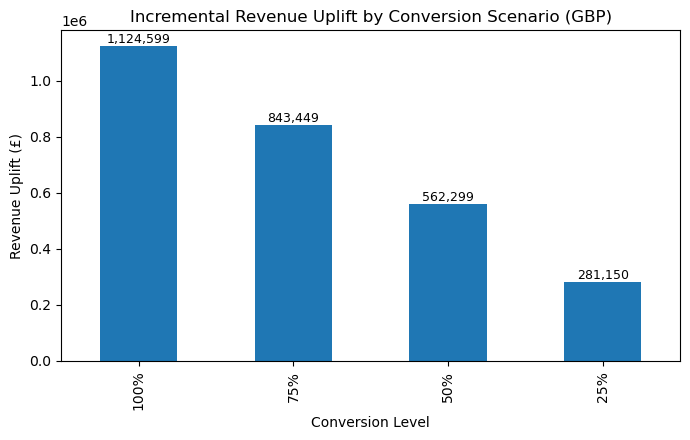

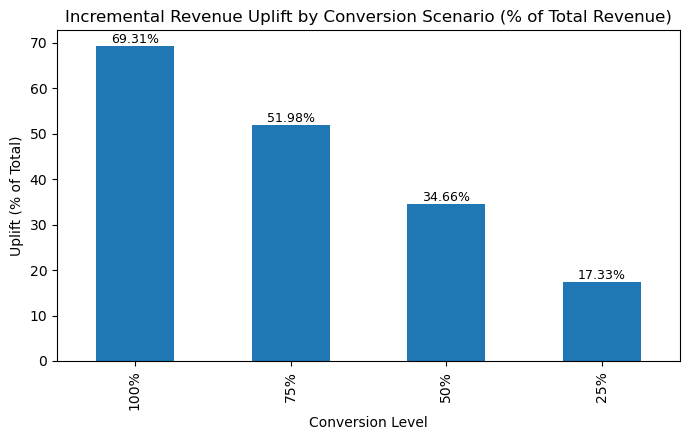

In [81]:
# --- Chart 1: Absolute uplift in GBP ---
plt.figure(figsize=(7,4.5))
Rev_uplift_conversion["Revenue_Uplift_GBP"].plot(kind="bar")
plt.title("Incremental Revenue Uplift by Conversion Scenario (GBP)")
plt.xlabel("Conversion Level")
plt.ylabel("Revenue Uplift (£)")
# Add value labels on bars
for i, v in enumerate(Rev_uplift_conversion["Revenue_Uplift_GBP"].values):
    plt.text(i, v, f"{v:,.0f}", ha="center", va="bottom", fontsize=9, rotation=0)
plt.tight_layout()
plt.show()

# --- Chart 2: Uplift as % of total revenue ---
plt.figure(figsize=(7,4.5))
Rev_uplift_conversion["Revenue_Uplift_%_of_Total"].plot(kind="bar")
plt.title("Incremental Revenue Uplift by Conversion Scenario (% of Total Revenue)")
plt.xlabel("Conversion Level")
plt.ylabel("Uplift (% of Total)")
# Add value labels on bars
for i, v in enumerate(Rev_uplift_conversion["Revenue_Uplift_%_of_Total"].values):
    plt.text(i, v, f"{v:.2f}%", ha="center", va="bottom", fontsize=9, rotation=0)
plt.tight_layout()
plt.show()

Insights for Domestic market:

1. 62% of revenue is coming from 16% of customers (i.e. VIP/Champions)- Pareto-like Effect (80-20 rule)
2. Domestic customers are more frequent but lower value (AOV); promotions should prioritize retention over acquisition.

Proposed actions:
0. A blended strategy — logistics improvement abroad + personalized retention at home — maximizes global (intl+dom) ROI.
1. VIP segment: Cross-selling high-margin items and offering exclusive access as consumers value recognition for their status.
2. Create VIP tiers with free shipping, early product access, and personalized recommendations.
3. Launch holiday bundles mixing high-margin items with frequent purchases to increase basket size.



Conversion from Potential loyalists to Loyal customers 
Rational: potential loyalits segment has the 38% of total customer base nudge them and reactivate their loyalty

Insights from Conversion scenario:
1. With 100% conversion, revenue uplift is 1124598.97. This is an increase of 69.31% in total revenue.
2. With 25% conversion, revenue uplift is: 281149.74. This is an increase of 17.33% in total revenue.

Proposed actions:
1. Personalized “we miss you” or “reactivation” offers
2. emphasize exclusivity or limited-time loyalty incentives


## International Market Insights

In [77]:
# Add log transformation to the international segments data
rfm_intl_segments['log_Frequency'] = np.log(rfm_intl_segments['Frequency'])
rfm_intl_segments['log_Monetary'] = np.log(rfm_intl_segments['Monetary'])

# Define function to loop over each country to fit this model separately.
elasticity_results = []

for country, subset in rfm_intl_segments.groupby("Country"):
    if len(subset) > 10:  # ensure at least 10 data points
        X = sm.add_constant(subset["log_Frequency"])
        y = subset["log_Monetary"]
        model = sm.OLS(y, X).fit()
        
        elasticity_results.append({
            "Country": country,
            "Elasticity_β": round(model.params["log_Frequency"], 3),
            "R2": round(model.rsquared, 3),
            "p_value": round(model.pvalues["log_Frequency"], 4)
        })

elasticity_df = pd.DataFrame(elasticity_results)

elasticity_df = elasticity_df.sort_values("Elasticity_β", ascending=False)

#identify top responsive countries with elasticity >1, R2>0.6 (good model fit) and p_value<0.05 (statistically significant)
top_responsive_countries = elasticity_df[
    (elasticity_df["Elasticity_β"] > 1.0) &
    (elasticity_df["R2"] > 0.6) &
    (elasticity_df["p_value"] < 0.05)
].sort_values("Elasticity_β", ascending=False)

top_responsive_countries


,Country,Elasticity_β,R2,p_value
3,France,1.250,0.751,0.0000
2,Finland,1.072,0.661,0.0013
6,Portugal,1.060,0.641,0.0000
4,Germany,1.025,0.638,0.0000


Elasticity Interpretations:
1. Elasticity > 1.0: Spending grows faster than frequency (highly responsive markets).
2. Elasticity ≈ 1.0: Proportional response (steady markets).
3. Elasticity < 1.0: Diminishing returns — additional orders yield smaller spending growth.


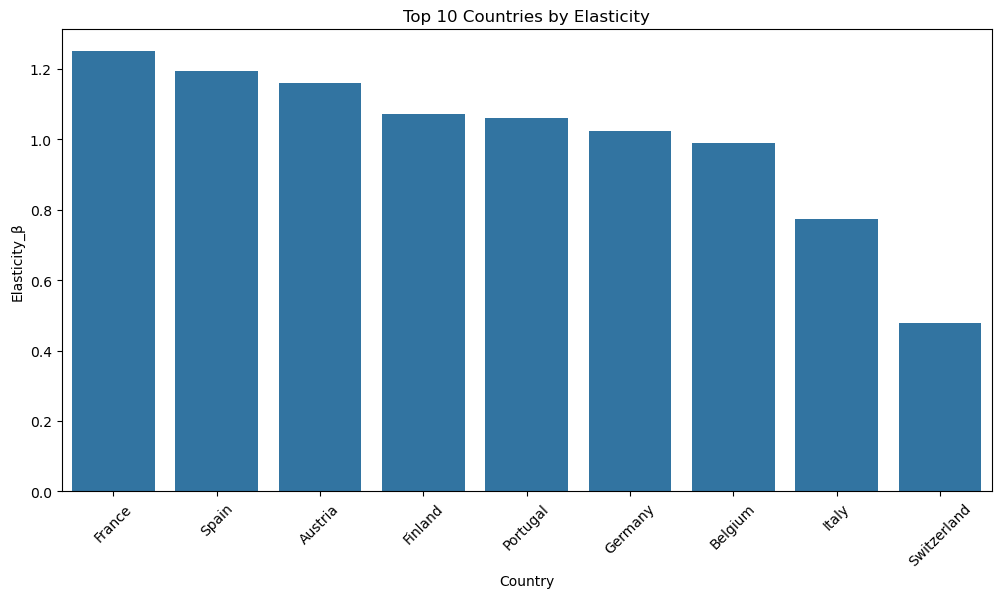

In [79]:
# Using elasticity_df and country-level averages from previous analysis
country_avg = (
    rfm_intl_segments.groupby("Country", as_index=False)
        .agg(Avg_Frequency=("Frequency","mean"),
             Avg_Monetary=("Monetary","mean"))
)

# Merge elasticity with averages
uplift_df = elasticity_df.merge(country_avg, on="Country", how="left")

# Calculate %ΔF, %ΔR, and INR increase per added order
uplift_df["%_Change_Freq_per_Order"] = (1 / uplift_df["Avg_Frequency"]) * 100
uplift_df["%_Change_Revenue"] = uplift_df["Elasticity_β"] * uplift_df["%_Change_Freq_per_Order"]
uplift_df["Revenue_Increase_per_Customer_GBP"] = (uplift_df["Avg_Monetary"] *
                                                  uplift_df["%_Change_Revenue"] / 100).round(2)

#
uplift_df[["Country","Elasticity_β","Avg_Frequency","Avg_Monetary",
           "Revenue_Increase_per_Customer_GBP"]].head(10)

#visualize elasticity results
plt.figure(figsize=(12, 6))
sns.barplot(data=uplift_df.sort_values("Elasticity_β", ascending=False).head(10),
            x="Country", y="Elasticity_β")
plt.title("Top 10 Countries by Elasticity")
plt.xticks(rotation=45)
plt.show()

Insights for International Market:

1. Internationally, VIPs alone produce 72 % of sales (1.17 M of 1.62 M) with an average spend 2 × higher than UK VIPs, signalling greater affluence and willingness to pay. [insert AOV value graph from EDA]
2. Monetary–Frequency correlation (0.7) confirms that increasing repeat purchase behavior (frequency) is the most powerful lever for revenue growth internationally.

Considering M-F correlation of 0.7, we can use elasticity analysis for frequency and revenue:  
1. France, Spain, and Austria (highly elastic markets) show the best elasticity-to-revenue ratio. Every extra purchase there generates £700–£850 incremental revenue.
2. Germany, Portugal, Finland are moderately responsive markets. Intorduce engagement incentives will stabilize repeat purchases.
3. Italy and Switzerland need value-per-transaction rather than frequency campaigns.


Proposed actions:
1. High responsive markets: Prioritize retention & reorder incentives through auto-reorder emails and purchase frequency rewards
2. Moderately responsive markets: divide discounts by elasticity — e.g., higher loyalty incentives in high-elasticity markets, upsell in low-elasticity

Future Analysis:
1. Elasticity modeling combined with RFM based segmentation can be updated quarterly to track responsiveness changes.

